In [4]:
# Python 3 compatability
from __future__ import division, print_function
from builtins import range

# system functions that are always useful to have
import time, sys, os

# basic numeric setup
import numpy as np
import math
from numpy import linalg
from scipy.interpolate import interp1d, RegularGridInterpolator
from astropy.cosmology import Planck13 as cosmo
import sys, time

# inline plotting
%matplotlib inline


# plotting
import matplotlib
from matplotlib import pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import seaborn as sea
# seed the random number generator
np.random.seed(7)

from spec_exam import Gen_spec
from sim_engine import forward_model_grism, Salmon, F_lam_per_M
import fsps
from spec_id import *
from spec_tools import Oldest_galaxy, Photometry
from spec_stats import Highest_density_region

import dynesty
from dynesty import plotting as dyplot
from glob import glob

from dynesty.dynamicsampler import stopping_function, weight_function
from dynesty.utils import quantile as _quantile
from scipy.ndimage import gaussian_filter as norm_kde

from prospect.models.transforms import logsfr_ratios_to_masses
from multiprocessing import Pool
from scipy import stats
from scipy.special import erf, erfinv

import george
from george import kernels

In [2]:
sp = fsps.StellarPopulation(imf_type = 2, tpagb_norm_type=0, zcontinuous = 1, logzsol = 0, sfh = 3, dust_type = 1)
# sp = fsps.StellarPopulation(imf_type = 2, tpagb_norm_type=0, zcontinuous = 1, logzsol = 0, sfh = 1, tau=0.1, dust_type = 1)

Gs = Gen_spec('GND', 21156, 1.2550,
               g102_lims=[8300, 11288], g141_lims=[11288, 16500],mdl_err = False,
            phot_errterm = 0.03, irac_err = 0.06, decontam = True) 

cleaned


/Users/vestrada/miniconda3/envs/astroconda/lib/python3.5/site-packages/grizli-0.8.0_4_g1153432-py3.5-macosx-10.6-x86_64.egg/grizli/model.py:548: RuntimeWarning: invalid value encountered in true_divide
  self.optimal_profile = m/m.sum(axis=0)
/Users/vestrada/miniconda3/envs/astroconda/lib/python3.5/site-packages/grizli-0.8.0_4_g1153432-py3.5-macosx-10.6-x86_64.egg/grizli/model.py:3423: RuntimeWarning: divide by zero encountered in true_divide
  self.ivar = 1/self.grism.data['ERR']**2


In [48]:
###############
###set prior###
###############
specz = 1.2550
agelim = Oldest_galaxy(specz)

def prior(u):
    m = Gaussian_prior(u[0], [0.002,0.03], 0.019, 0.08)/ 0.019
    a = (agelim - 1)* u[1] + 1
    
    tsamp = np.array([u[2],u[3],u[4],u[5],u[6],u[7],u[8],u[9], u[10], u[11]])

    taus = stats.t.ppf( q = tsamp, loc = 0, scale = 0.3, df =2.)

    m1, m2, m3, m4, m5, m6, m7, m8, m9, m10 = logsfr_ratios_to_masses(logmass = 0, logsfr_ratios = taus, agebins = get_agebins(a)) * 1E9
    
    z = stats.norm.ppf(u[12],loc = specz, scale = 0.005)
    
    d = u[13]
    
    bp1 = Gaussian_prior(u[14], [-0.5,0.5], 0, 0.25)
    
    rp1 = Gaussian_prior(u[15], [-0.5,0.5], 0, 0.25)
        
    ba = log_10_prior(u[16], [0.1,10])
    bb = log_10_prior(u[17], [0.0001,1])
    bl = log_10_prior(u[18], [0.01,1])
    
    ra = log_10_prior(u[19], [0.1,10])
    rb = log_10_prior(u[20], [0.0001,1])
    rl = log_10_prior(u[21], [0.01,1])
            
    lwa = get_lwa([m, a, m1, m2, m3, m4, m5, m6, m7, m8, m9, m10], get_agebins(a),sp)[0]

    return [m, a, m1, m2, m3, m4, m5, m6, m7, m8, m9, m10, z, d, bp1, rp1, ba, bb, bl, ra, rb, rl, lwa]

sp.params['logzsol'] = 0

def phot_prior(u):
#     m = Gaussian_prior(u[0], [0.002,0.03], 0.019, 0.08)/ 0.019
    a = (agelim - 1)* u[0] + 1
    
    tsamp = np.array([u[1],u[2],u[3],u[4],u[5],u[6],u[7],u[8], u[9], u[10]])

    taus = stats.t.ppf( q = tsamp, loc = 0, scale = 0.3, df =2.)

    m1, m2, m3, m4, m5, m6, m7, m8, m9, m10 = logsfr_ratios_to_masses(logmass = 0, logsfr_ratios = taus, agebins = get_agebins(a)) * 1E9
    
    z = stats.norm.ppf(u[11],loc = specz, scale = 0.005)
    
    d = u[12]
            
    lwa = get_lwa([1, a, m1, m2, m3, m4, m5, m6, m7, m8, m9, m10], get_agebins(a),sp)[0]

#     return [m, a, m1, m2, m3, m4, m5, m6, m7, m8, m9, m10, z, d, lwa]
    return [a, m1, m2, m3, m4, m5, m6, m7, m8, m9, m10, z, d, lwa]

def g102_prior(u):
    m = Gaussian_prior(u[0], [0.002,0.03], 0.019, 0.08)/ 0.019
    a = (agelim - 1)* u[1] + 1
    
    tsamp = np.array([u[2],u[3],u[4],u[5],u[6],u[7],u[8],u[9], u[10], u[11]])

    taus = stats.t.ppf( q = tsamp, loc = 0, scale = 0.3, df =2.)

    m1, m2, m3, m4, m5, m6, m7, m8, m9, m10 = logsfr_ratios_to_masses(logmass = 0, logsfr_ratios = taus, agebins = get_agebins(a)) * 1E9
    
    z = stats.norm.ppf(u[12],loc = specz, scale = 0.005)
    
    d = u[13]
    
    bp1 = Gaussian_prior(u[14], [-0.5,0.5], 0, 0.25)
           
    ba = log_10_prior(u[15], [0.1,10])
    bb = log_10_prior(u[16], [0.0001,1])
    bl = log_10_prior(u[17], [0.01,1])
       
    lwa = get_lwa([m, a, m1, m2, m3, m4, m5, m6, m7, m8, m9, m10], get_agebins(a),sp)[0]

    return [m, a, m1, m2, m3, m4, m5, m6, m7, m8, m9, m10, z, d, bp1, ba, bb, bl, lwa]


def g141_prior(u):
    m = Gaussian_prior(u[0], [0.002,0.03], 0.019, 0.08)/ 0.019
    a = (agelim - 1)* u[1] + 1
    
    tsamp = np.array([u[2],u[3],u[4],u[5],u[6],u[7],u[8],u[9], u[10], u[11]])

    taus = stats.t.ppf( q = tsamp, loc = 0, scale = 0.3, df =2.)

    m1, m2, m3, m4, m5, m6, m7, m8, m9, m10 = logsfr_ratios_to_masses(logmass = 0, logsfr_ratios = taus, agebins = get_agebins(a)) * 1E9
    
    z = stats.norm.ppf(u[12],loc = specz, scale = 0.005)
    
    d = u[13]
       
    rp1 = Gaussian_prior(u[14], [-0.5,0.5], 0, 0.25)
    
    ra = log_10_prior(u[15], [0.1,10])
    rb = log_10_prior(u[16], [0.0001,1])
    rl = log_10_prior(u[17], [0.01,1])
            
    lwa = get_lwa([m, a, m1, m2, m3, m4, m5, m6, m7, m8, m9, m10], get_agebins(a),sp)[0]

    return [m, a, m1, m2, m3, m4, m5, m6, m7, m8, m9, m10, z, d, rp1, ra, rb, rl, lwa]

In [49]:
def Full_forward_model(spec, wave, flux, specz):
    Gmfl = []
    
    for i in range(len(wvs)):
        Gmfl.append(forward_model_all_beams(beams[i], trans[i], wvs[i], wave * (1 + specz), flux))

    Pmfl = spec.Sim_phot_mult(wave * (1 + specz),flux)

    return np.array(Gmfl), Pmfl

def Full_calibrate(Gmfl, p1):
    for i in range(len(wvs)):
        Gmfl[i] = Gmfl[i] * ((p1[i] * wvs[i]) / (wvs[i][-1] - wvs[i][0]) + 5)
    return Gmfl

def Calibrate_grism(spec, Gmfl, p1):
    linecal = []
    for i in range(len(wvs)):
        lines = ((p1[i] * wvs[i]) / (wvs[i][-1] - wvs[i][0]) + 5)
        scale = Scale_model(flxs[i]  / lines, errs[i] / lines, Gmfl[i])    
        linecal.append(scale * lines)
        
    return linecal


def Full_fit(spec, Gmfl, Pmfl):
    Gchi = 0
    
    for i in range(len(wvs)):
        scale = Scale_model(flxs[i], errs[i], Gmfl[i])
        Gchi = Gchi + np.sum(((((flxs[i] / scale) - Gmfl[i]) / (errs[i] / scale))**2))
    
    Pchi = np.sum((((spec.Pflx - Pmfl) / spec.Perr)**2)) * -0.5

    return Gchi, Pchi

def Full_fit_2(spec, Gmfl, Pmfl, a, b, l): 
    Gln = 0
    
    for i in range(len(wvs)):
        scale = Scale_model(flxs[i], errs[i], Gmfl[i])
        noise = noise_model(np.array([wvs[i],flxs[i], errs[i]]).T, Gmfl[i] * scale)
        noise.GP_exp_squared(a[i],b[i],l[i])
        Gln += noise.gp.lnlikelihood(noise.diff)

    Pln = lnlike_phot(spec.Pflx, spec.Perr, Pmfl)
    
    return Gln + Pln

def tab_L(X):
    m, a, m1, m2, m3, m4, m5, m6, m7, m8, m9, m10, z, d, bp1, rp1, ba, bb, bl, ra, rb, rl, lwa = X
    
    sp.params['dust2'] = d
    sp.params['dust1'] = d
    sp.params['logzsol'] = np.log10(m)

    time, sfr, tmax = convert_sfh(get_agebins(a), [m1, m2, m3, m4, m5, m6, m7, m8, m9, m10], maxage = a*1E9)

    sp.set_tabular_sfh(time,sfr)    
    
    wave, flux = sp.get_spectrum(tage = a, peraa = True)

    Gmfl, Pmfl = Full_forward_model(Gs, wave, flux, z)
       
    Gmfl = Full_calibrate(Gmfl, [bp1, rp1])
        
    PC= Full_scale(Gs, Pmfl)

    LOGL = Full_fit_2(Gs, Gmfl, PC*Pmfl, [ba,ra], [bb,rb], [bl, rl])
                 
#     return -0.5 * (Pchi+Gchi)

    return LOGL

def phot_L(X):
#     m, a, m1, m2, m3, m4, m5, m6, m7, m8, m9, m10, z, d, lwa = X
    a, m1, m2, m3, m4, m5, m6, m7, m8, m9, m10, z, d, lwa = X
    
    sp.params['dust2'] = d
    sp.params['dust1'] = d
#     sp.params['logzsol'] = np.log10(m)

    time, sfr, tmax = convert_sfh(get_agebins(a), [m1, m2, m3, m4, m5, m6, m7, m8, m9, m10], maxage = a*1E9)

    sp.set_tabular_sfh(time,sfr)    
    
    wave, flux = sp.get_spectrum(tage = a, peraa = True)

    Pmfl = Gs.Sim_phot_mult(wave * (1 + z),flux)
       
    PC= Full_scale(Gs, Pmfl)

    return lnlike_phot(Gs.Pflx, Gs.Perr, PC*Pmfl)

def g102_L(X):
    m, a, m1, m2, m3, m4, m5, m6, m7, m8, m9, m10, z, d, bp1, ba, bb, bl, lwa = X    
    sp.params['dust2'] = d
    sp.params['dust1'] = d
    sp.params['logzsol'] = np.log10(m)

    time, sfr, tmax = convert_sfh(get_agebins(a), [m1, m2, m3, m4, m5, m6, m7, m8, m9, m10], maxage = a*1E9)

    sp.set_tabular_sfh(time,sfr)    
    
    wave, flux = sp.get_spectrum(tage = a, peraa = True)

    Gmfl = forward_model_all_beams(Gs.Bbeam, Gs.Btrans, Gs.Bwv, wave * (1 + z), flux)
    
    Gmfl = Gmfl * ((bp1 *Gs.Bwv) / (Gs.Bwv[-1] - Gs.Bwv[0]) + 5)

    scale =   Scale_model(Gs.Bfl, Gs.Ber, Gmfl)

    noise = noise_model(np.array([Gs.Bwv,Gs.Bfl, Gs.Ber]).T, Gmfl * scale)
    noise.GP_exp_squared(ba,bb,bl)
    
    return noise.gp.lnlikelihood(noise.diff)

def g141_L(X):
    m, a, m1, m2, m3, m4, m5, m6, m7, m8, m9, m10, z, d, rp1, ra, rb, rl, lwa = X    
    sp.params['dust2'] = d
    sp.params['dust1'] = d
    sp.params['logzsol'] = np.log10(m)

    time, sfr, tmax = convert_sfh(get_agebins(a), [m1, m2, m3, m4, m5, m6, m7, m8, m9, m10], maxage = a*1E9)

    sp.set_tabular_sfh(time,sfr)    
    
    wave, flux = sp.get_spectrum(tage = a, peraa = True)

    Gmfl = forward_model_all_beams(Gs.Rbeam, Gs.Rtrans, Gs.Rwv, wave * (1 + z), flux)
    
    Gmfl = Gmfl * ((rp1 *Gs.Rwv) / (Gs.Rwv[-1] - Gs.Rwv[0]) + 5)

    scale = Scale_model(Gs.Rfl, Gs.Rer, Gmfl)

    noise = noise_model(np.array([Gs.Rwv,Gs.Rfl, Gs.Rer]).T, Gmfl * scale)
    noise.GP_exp_squared(ra,rb,rl)
    
    return noise.gp.lnlikelihood(noise.diff)

In [50]:
dsampler = dynesty.NestedSampler(phot_L, phot_prior, ndim = 14, pool=Pool(processes=16), queue_size=16)

/Users/vestrada/miniconda3/envs/astroconda/lib/python3.5/site-packages/dynesty/sampling.py:207: UserWarning: Random number generation appears to be extremely inefficient. Adjusting the scale-factor accordingly.
  warnings.warn("Random number generation appears to be "
/Users/vestrada/miniconda3/envs/astroconda/lib/python3.5/site-packages/dynesty/sampling.py:207: UserWarning: Random number generation appears to be extremely inefficient. Adjusting the scale-factor accordingly.
  warnings.warn("Random number generation appears to be "


Exception while calling loglikelihood function:
Exception while calling prior_transform function:
  params: [0.77496426 0.43249274 0.79714127 0.02860398 0.46897354 0.34270283
 0.41906167 0.51376153 0.02592684 0.35427073 0.2850822  0.2212173
 0.00363066 0.63651872]
  args: []
  kwargs: {}
  exception:
Exception while calling loglikelihood function:
Exception while calling prior_transform function:
Exception while calling loglikelihood function:
Exception while calling prior_transform function:
Exception while calling loglikelihood function:
Exception while calling loglikelihood function:
Exception while calling loglikelihood function:
Exception while calling loglikelihood function:
Exception while calling prior_transform function:
Exception while calling prior_transform function:
Exception while calling prior_transform function:
Exception while calling prior_transform function:
Exception while calling loglikelihood function:
Exception while calling loglikelihood function:
  params: [0.6

Traceback (most recent call last):
  File "/Users/vestrada/miniconda3/envs/astroconda/lib/python3.5/site-packages/dynesty/dynesty.py", line 805, in __call__
    return self.func(x, *self.args, **self.kwargs)
  File "<ipython-input-48-d87e1f75ffd3>", line 47, in phot_prior
    m1, m2, m3, m4, m5, m6, m7, m8, m9, m10 = logsfr_ratios_to_masses(logmass = 0, logsfr_ratios = taus, agebins = get_agebins(a)) * 1E9
  File "/Users/vestrada/miniconda3/envs/astroconda/lib/python3.5/site-packages/prospect-0.2-py3.5.egg/prospect/models/transforms.py", line 146, in logsfr_ratios_to_masses
    sratios = 10**logsfr_ratios
KeyboardInterrupt
Process ForkPoolWorker-113:
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent cal

In [51]:
dsampler.run_nested(print_progress=True)

dres = dsampler.results

iter: 3960 | bound: 36 | nc: 25 | ncall: 75090 | eff(%):  5.274 | loglstar:   -inf < 828.377 <    inf | logz: 818.491 +/-  0.133 | dlogz: 23.354 >  0.509                                             

KeyboardInterrupt: 

In [34]:
bsampler = dynesty.NestedSampler(g102_L, g102_prior, ndim = 18, pool=Pool(processes=16), queue_size=16)

/Users/vestrada/miniconda3/envs/astroconda/lib/python3.5/site-packages/dynesty/sampling.py:207: UserWarning: Random number generation appears to be extremely inefficient. Adjusting the scale-factor accordingly.
  warnings.warn("Random number generation appears to be "
/Users/vestrada/miniconda3/envs/astroconda/lib/python3.5/site-packages/dynesty/sampling.py:207: UserWarning: Random number generation appears to be extremely inefficient. Adjusting the scale-factor accordingly.
  warnings.warn("Random number generation appears to be "
/Users/vestrada/miniconda3/envs/astroconda/lib/python3.5/site-packages/dynesty/sampling.py:207: UserWarning: Random number generation appears to be extremely inefficient. Adjusting the scale-factor accordingly.
  warnings.warn("Random number generation appears to be "
/Users/vestrada/miniconda3/envs/astroconda/lib/python3.5/site-packages/dynesty/sampling.py:207: UserWarning: Random number generation appears to be extremely inefficient. Adjusting the scale-fa

In [35]:
bsampler.run_nested(print_progress=True)

bres = bsampler.results

iter: 6380 | +500 | bound: 69 | nc: 1 | ncall: 136082 | eff(%):  5.056 | loglstar:   -inf < 260.046 <    inf | logz: 247.923 +/-  0.156 | dlogz:  0.001 >  0.509                                      

In [42]:
rsampler = dynesty.NestedSampler(g141_L, g141_prior, ndim = 18, pool=Pool(processes=16), queue_size=16)

/Users/vestrada/miniconda3/envs/astroconda/lib/python3.5/site-packages/dynesty/sampling.py:207: UserWarning: Random number generation appears to be extremely inefficient. Adjusting the scale-factor accordingly.
  warnings.warn("Random number generation appears to be "
/Users/vestrada/miniconda3/envs/astroconda/lib/python3.5/site-packages/dynesty/sampling.py:207: UserWarning: Random number generation appears to be extremely inefficient. Adjusting the scale-factor accordingly.
  warnings.warn("Random number generation appears to be "
/Users/vestrada/miniconda3/envs/astroconda/lib/python3.5/site-packages/dynesty/sampling.py:207: UserWarning: Random number generation appears to be extremely inefficient. Adjusting the scale-factor accordingly.
  warnings.warn("Random number generation appears to be "
/Users/vestrada/miniconda3/envs/astroconda/lib/python3.5/site-packages/dynesty/sampling.py:207: UserWarning: Random number generation appears to be extremely inefficient. Adjusting the scale-fa

In [43]:
rsampler.run_nested(print_progress=True)

rres = rsampler.results

iter: 6045 | +500 | bound: 64 | nc: 1 | ncall: 128181 | eff(%):  5.106 | loglstar:   -inf < 195.547 <    inf | logz: 184.099 +/-  0.154 | dlogz:  0.001 >  0.509                                      

(<Figure size 864x4104 with 38 Axes>,
 array([[<matplotlib.axes._subplots.AxesSubplot object at 0x1a90154c88>,
       dtype=object))

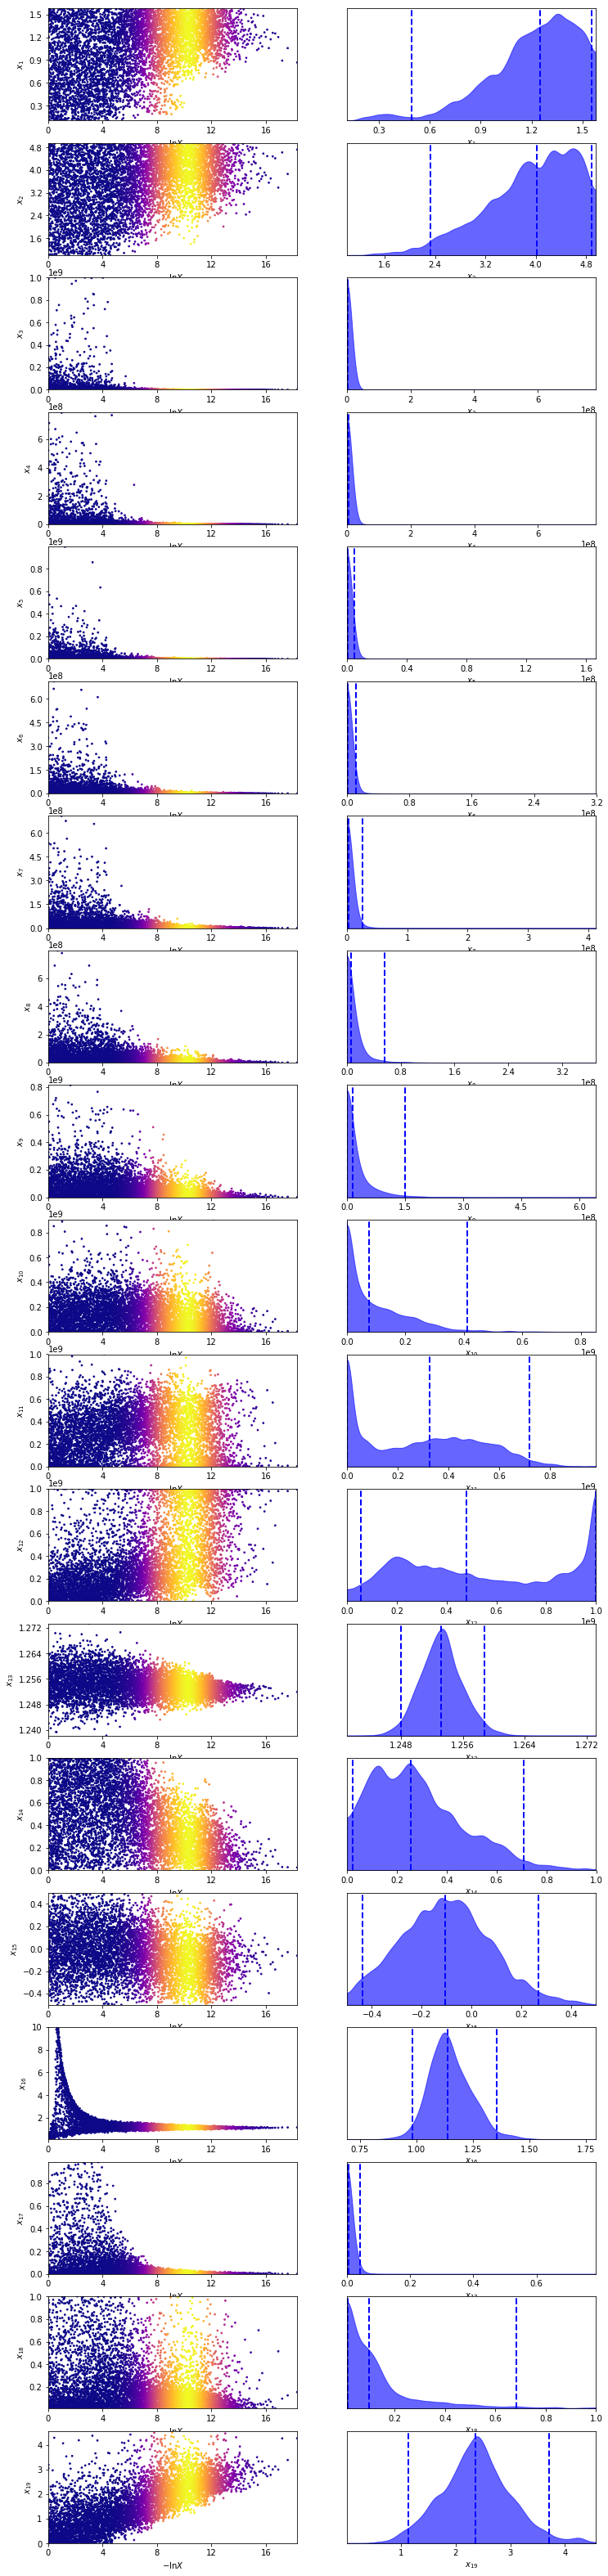

In [44]:
dyplot.traceplot(rres)

(<Figure size 2815.2x2815.2 with 324 Axes>,
 array([[<matplotlib.axes._subplots.AxesSubplot object at 0x1a9b11b518>,
       dtype=object))

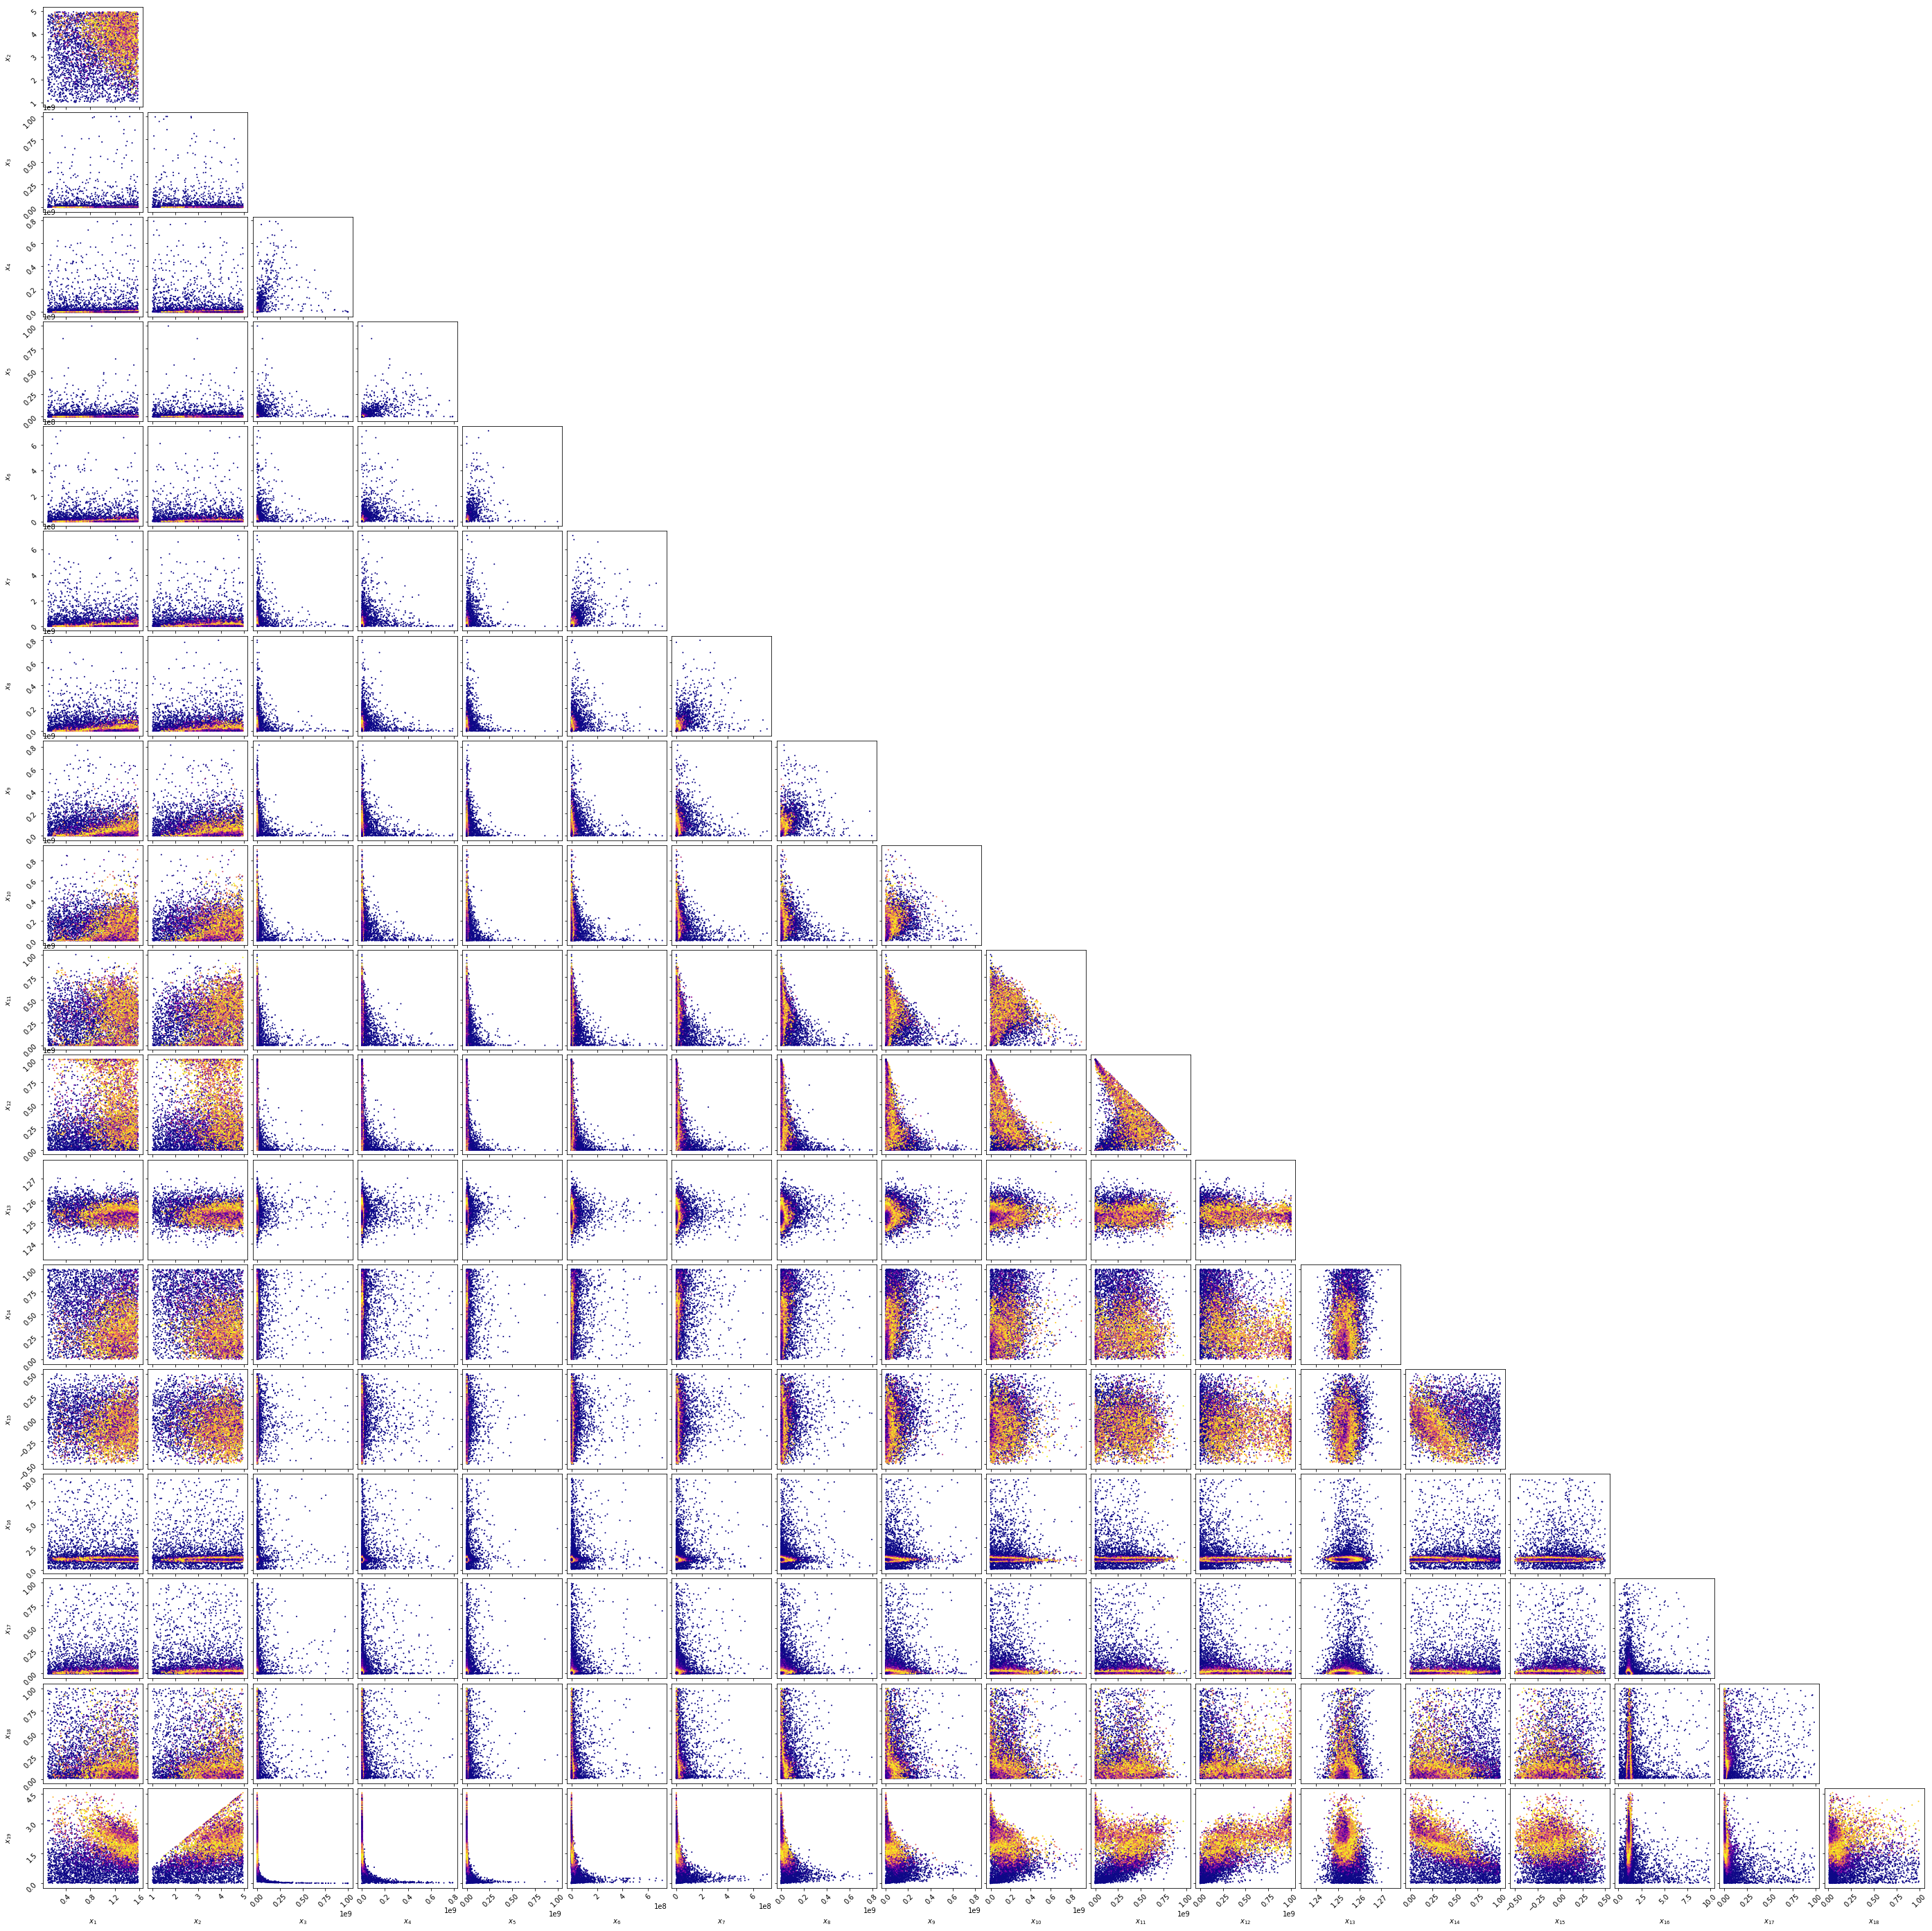

In [45]:
dyplot.cornerpoints(rres)